# Particle Filter

## Code for robot spawn, move and sense

In [203]:
# In this exercise, try to write a program that
# will resample particles according to their weights.
# Particles with higher weights should be sampled
# more frequently (in proportion to their weight).

# Don't modify anything below. Please scroll to the 
# bottom to enter your code.

from math import *
import random

landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 0.0;
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')      
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        
        prob = 1.0;
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

## Task 1

In this case, all noise parameters are 0

In [204]:
# starts at 30.0, 50.0, heading north (=pi/2)
# turns clockwise by pi/2, moves 15 meters
# senses
# turns clockwise by pi/2, moves 10 meters
# senses


In [205]:
my_robot = robot()
my_robot.set(30.,50.,pi/2)
my_robot = my_robot.move(-pi/2, 15)
print(f"Landmarks at: {my_robot.sense()}")
my_robot = my_robot.move(-pi/2, 10)
print(f"Landmarks at: {my_robot.sense()}")
print(f"Robot at {my_robot}")

Landmarks at: [39.05124837953327, 46.09772228646444, 39.05124837953327, 46.09772228646444]
Landmarks at: [32.01562118716424, 53.150729063673246, 47.16990566028302, 40.311288741492746]
Robot at [x=45.0 y=40.0 orient=4.7123]


## Task 2
Adding noise parameters

In [206]:
# forward_noise = 5.0, turn_noise = 0.1, sense_noise = 5.0
# rest is same as task 1
# starts at 30.0, 50.0, heading north (=pi/2)
# turns clockwise by pi/2, moves 15 meters
# senses
# turns clockwise by pi/2, moves 10 meters
# senses

In [207]:
f_noise = 5.0
t_noise = 0.1
s_noise = 5.0

In [208]:
my_robot = robot()
my_robot.set(30.,50.,pi/2)
# adding noise parameters
my_robot.set_noise(f_noise, t_noise, s_noise)
my_robot = my_robot.move(-pi/2, 15)
print(f"Landmarks at: {my_robot.sense()}")
my_robot = my_robot.move(-pi/2, 10)
print(f"Landmarks at: {my_robot.sense()}")
print(f"Robot at {my_robot}")

Landmarks at: [42.414560269555444, 46.299547124843826, 36.72866283981884, 52.39853567469454]
Landmarks at: [30.928286255887485, 52.506714457394466, 51.95642020169324, 52.173627323310825]
Robot at [x=47.985 y=41.248 orient=4.8146]


## Create particles

In [218]:
N = 1000
# create n particles

particles = [robot() for i in range(N)]

len(particles)

1000

## Move particles

In [219]:
# turn by 0.1 , and move by 5
p_moved = [x.move(0.1, 5) for x in particles]

In [220]:
particles[0], p_moved[0]

([x=82.494 y=11.904 orient=5.1673], [x=85.129 y=7.6546 orient=5.2673])

## Task 3

Make weights to assign each particle where  
> $weights \propto$ error b/w predicted location of landmarks from particle, and actual measurement

In [221]:
print("Robot at: ",my_robot)
z = my_robot.sense()
print(f"Measurement of landmarks by robot: {z}")

Robot at:  [x=47.985 y=41.248 orient=4.8146]
Measurement of landmarks by robot: [41.27329177113256, 53.47482172037687, 46.01458211244268, 46.0355153714474]


In [222]:
## again create particles, but this time, set noise (otherwise measurement prob will return error)
N = 1000
# create n particles

particles = [robot() for i in range(N)]
_ = [x.set_noise(0.05, 0.05, 5.0) for x in particles]
len(particles)

1000

In [223]:
# turn by 0.1 , and move by 5
particles = [x.move(0.1, 5) for x in particles]

In [224]:
particles

[[x=59.483 y=24.442 orient=3.9290],
 [x=53.722 y=50.622 orient=2.6896],
 [x=31.224 y=77.122 orient=1.9915],
 [x=52.306 y=29.784 orient=0.1506],
 [x=89.891 y=42.827 orient=4.9755],
 [x=29.012 y=25.679 orient=5.0534],
 [x=39.343 y=10.377 orient=2.1928],
 [x=39.717 y=59.324 orient=5.2122],
 [x=99.805 y=58.926 orient=2.4563],
 [x=93.969 y=41.475 orient=0.9416],
 [x=39.126 y=50.927 orient=2.4217],
 [x=62.509 y=3.1207 orient=3.2075],
 [x=38.397 y=19.649 orient=2.8629],
 [x=89.053 y=71.978 orient=4.6917],
 [x=58.309 y=22.743 orient=4.2268],
 [x=42.631 y=75.081 orient=3.2972],
 [x=67.617 y=24.795 orient=0.5781],
 [x=81.437 y=81.925 orient=0.7772],
 [x=58.145 y=30.788 orient=3.2164],
 [x=55.572 y=36.074 orient=2.3650],
 [x=43.686 y=83.760 orient=1.3903],
 [x=69.768 y=98.564 orient=1.5220],
 [x=52.745 y=92.351 orient=2.9854],
 [x=33.141 y=7.7994 orient=1.7377],
 [x=47.680 y=43.805 orient=5.9672],
 [x=11.853 y=10.429 orient=1.1393],
 [x=77.346 y=72.412 orient=1.2739],
 [x=36.858 y=68.354 orient=4

In [225]:
particles[0].forward_noise,particles[0].turn_noise,particles[0].sense_noise

(0.05, 0.05, 5.0)

In [227]:
probs_unnorm = [x.measurement_prob(z) for x in particles]
probs_unnorm

[3.9192856617199824e-15,
 2.733752527513869e-07,
 1.956251777143978e-25,
 8.818208491468482e-10,
 1.5291917771309506e-29,
 4.691627838227838e-18,
 5.071609637204241e-21,
 2.5273570012582217e-09,
 1.3184009902961452e-41,
 2.44992999126237e-33,
 9.414274508188914e-07,
 3.483018897542355e-30,
 8.829736521269023e-16,
 6.810117132966364e-43,
 2.476162804851567e-15,
 2.2182256089332313e-18,
 3.529708015981332e-21,
 2.158323612385801e-50,
 1.6366933520975563e-11,
 1.1633072088083365e-08,
 1.5331765705503965e-24,
 2.0347245481019644e-47,
 3.982480344168022e-32,
 1.2249726274117852e-25,
 7.836038849685388e-06,
 1.5110190952212853e-38,
 3.797420891678328e-36,
 2.2959502584439917e-15,
 5.7062617523019666e-39,
 8.52979111214908e-26,
 4.239982212876957e-38,
 6.907139872366665e-40,
 8.509063625898105e-12,
 5.629416793321195e-41,
 7.474120419720991e-27,
 3.4471741654403346e-20,
 1.9109007685971558e-41,
 1.6981854183696546e-48,
 2.611366279510843e-30,
 2.1934671236539187e-49,
 9.842079207792559e-14,
 

In [228]:
probs_unnorm_tot = sum(probs_unnorm)
probs = [x/probs_unnorm_tot for x in probs_unnorm]

## Sample particles (with replacement), using the prob. dist obtained

In [229]:
import matplotlib.pyplot as plt

%matplotlib widget

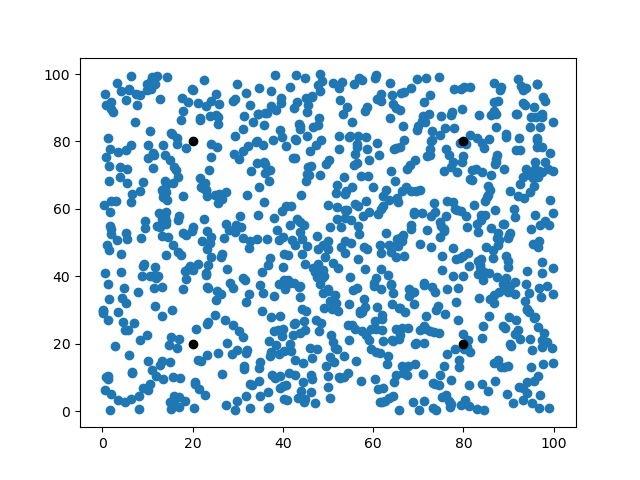

In [230]:
p_x, p_y = [p.x for p in particles], [p.y for p in particles]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y)
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

Here the number of particles is kept constant

### My method

In [240]:
p_new = []
added_indices = set()
while(len(p_new) < 1000):
    i = random.randint(0,N-1)
    if (random.random() < probs[i]):
        p_new.append(particles[i])
        added_indices.add(i)
    

In [241]:
p_new[i]

[x=44.805 y=43.703 orient=1.5707]

In [242]:
len(added_indices)

53

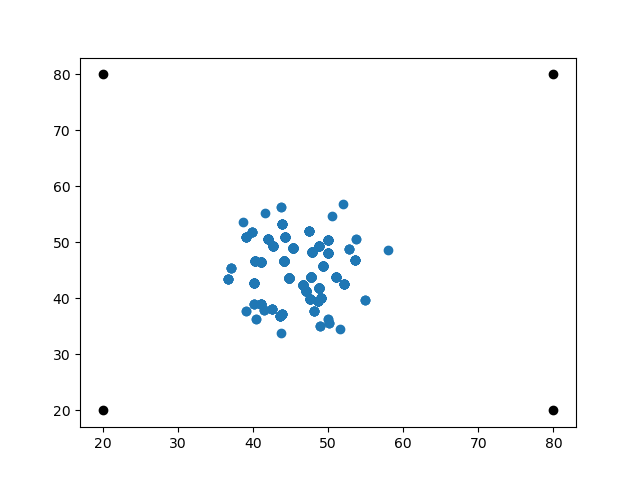

In [243]:
p_x, p_y = [p.x for p in p_new], [p.y for p in p_new]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y)
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

### Thrun method (Roulette Sampling)
Tried to implement by self

In [244]:
p_new = []

index = random.randint(0,N-1) # sample an index uniformly
beta = 0
probs_max = max(probs)
for i in range(N):
    beta += 2 * probs_max # step is wrong
    picked = False
    while not picked:
        if probs[index] < beta:
            beta -= probs[index]
            index = (index + 1) % N
        else:
            p_new.append(particles[index])
            picked = True
        

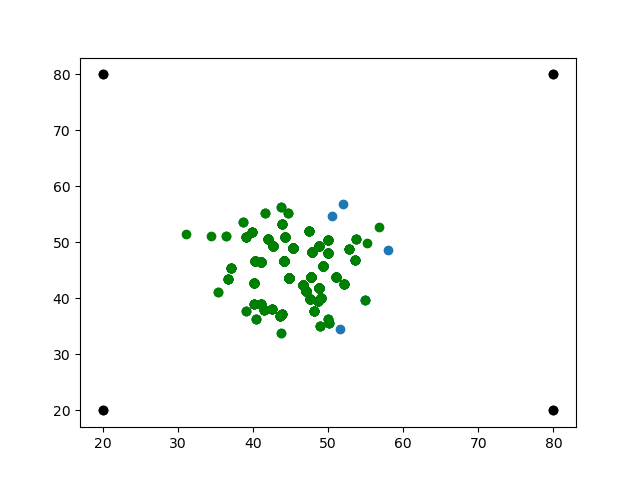

In [245]:
p_x, p_y = [p.x for p in p_new], [p.y for p in p_new]
# fig, ax = plt.subplots()
plt.scatter(p_x, p_y, color='g')
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

### Thrun Actual Roulette Implementation

In [246]:
p_new = []

index = random.randint(0,N-1) # sample an index uniformly
beta = 0
probs_max = max(probs)
for i in range(N):
    beta += random.random() * 2 * probs_max
    while probs[index] < beta:
        beta -= probs[index]
        index = (index + 1) % N
    p_new.append(particles[index])
        

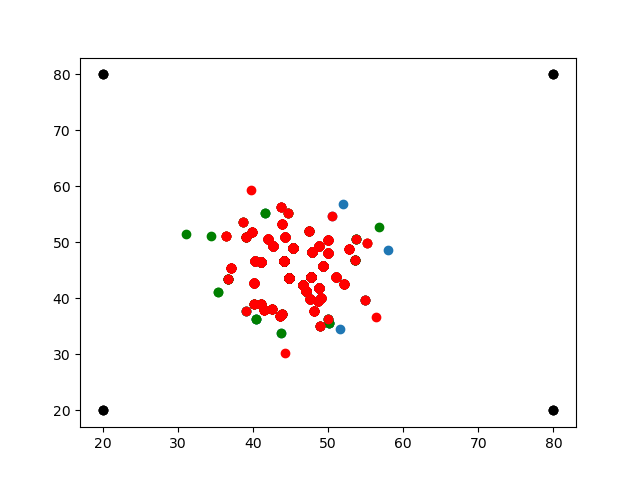

In [247]:
p_x, p_y = [p.x for p in p_new], [p.y for p in p_new]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y, color='r')
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

## Task 4

Run the loop twice

In [375]:
def filter_loop(N,motions, my_robot):
    # N = 1000
    # create n particles
    
    particles = [robot() for i in range(N)]
    _ = [x.set_noise(0.05, 0.05, 5.0) for x in particles]
    for i in range(len(motions)):
        my_robot = my_robot.move(motions[i][0], motions[i][1]) 
        particles = [x.move(motions[i][0], motions[i][1]) for x in particles]
        z = my_robot.sense()
        probs_unnorm = [x.measurement_prob(z) for x in particles]
        probs_unnorm_tot = sum(probs_unnorm)
        probs = [x/probs_unnorm_tot for x in probs_unnorm]

        # resample particles
        p_new = []
        index = random.randint(0,N-1) # sample an index uniformly
        beta = 0
        probs_max = max(probs)
        for j in range(N):
            beta += random.random() * 2 * probs_max
            while probs[index] < beta:
                beta -= probs[index]
                index = (index + 1) % N
            p_new.append(particles[index])
        particles = p_new
        print(i,perf_eval(my_robot, particles))
    return particles
        

In [434]:
# motions = [[0.1,5.0], [0.1, 5.0], [0.1,5.0]]
motions = [[0.1,5.0]] * 10
my_robot = robot()
# my_robot.set_noise(f_noise, t_noise, s_noise)
particles = filter_loop(1000, motions, my_robot)

0 4.3929082548998455
1 5.9626192841062196
2 7.20551236778174
3 8.587944936095607
4 7.394358730238144
5 7.2986507655299775
6 7.312681170384231
7 7.373919774706272
8 7.395908519813743
9 7.837883837947215


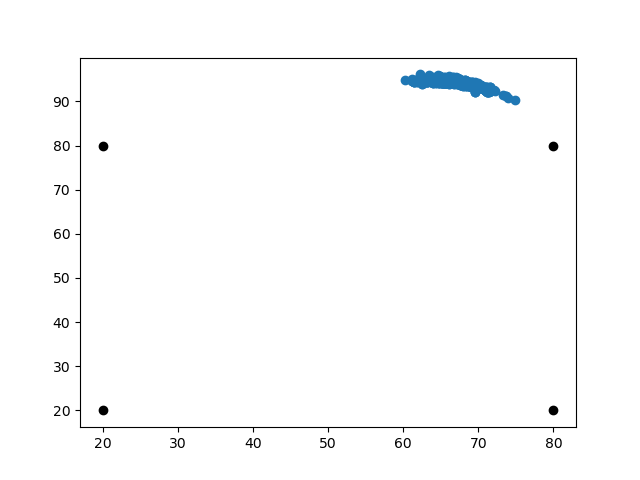

In [435]:
p_x, p_y = [p.x for p in particles], [p.y for p in particles]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y)
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

In [436]:
particles

[[x=68.884 y=94.108 orient=1.4890],
 [x=63.955 y=94.711 orient=1.7464],
 [x=68.293 y=93.687 orient=1.4309],
 [x=63.460 y=94.830 orient=1.8233],
 [x=63.716 y=94.781 orient=1.7761],
 [x=67.218 y=94.437 orient=1.5018],
 [x=69.676 y=93.684 orient=1.4700],
 [x=67.365 y=94.681 orient=1.4138],
 [x=62.870 y=94.643 orient=1.7831],
 [x=64.598 y=94.838 orient=1.6327],
 [x=65.092 y=94.421 orient=1.6841],
 [x=67.065 y=94.423 orient=1.6272],
 [x=71.444 y=92.257 orient=1.2664],
 [x=69.901 y=93.667 orient=1.3437],
 [x=63.543 y=94.817 orient=1.7530],
 [x=67.484 y=94.024 orient=1.5958],
 [x=67.213 y=94.522 orient=1.4818],
 [x=65.664 y=94.847 orient=1.6195],
 [x=64.542 y=94.537 orient=1.7370],
 [x=66.363 y=94.619 orient=1.5923],
 [x=67.959 y=94.111 orient=1.5373],
 [x=68.229 y=94.343 orient=1.3743],
 [x=63.839 y=94.711 orient=1.7303],
 [x=66.313 y=95.404 orient=1.4442],
 [x=68.883 y=93.685 orient=1.4123],
 [x=63.691 y=94.549 orient=1.7605],
 [x=66.123 y=94.553 orient=1.6634],
 [x=66.123 y=94.553 orient=1

## Evaluate

In [373]:
def perf_eval(my_robot, particles):
    sum = 0.0
    for i,p in enumerate(particles):
        dx = (p.x - my_robot.x + world_size/2) % world_size - (world_size/2) # dist calc in cyclic world
        dy = (p.y - my_robot.y + world_size/2) % world_size - (world_size/2)
        error = sqrt(dx**2 + dy**2) # euclidean error
        sum += error
    # return avg error
    return sum / len(particles)
    